# Within session changes

We want to see how the performance of the mice changes during the course of a session.

To analyze this, we calculate a trialNoScale, that ranges from 0 to 1. The score is calculated within each combination of session and light condition.

In [1]:
import pandas as pd
import numpy as np
import os.path
import importlib
import autopipy

from autopipy.project import Project
importlib.reload(autopipy.project)
from autopipy.project import Project

from autopipy.trial import Trial
importlib.reload(autopipy.trial)
from autopipy.trial import Trial

from autopipy.session import Session
importlib.reload(autopipy.session)
from autopipy.session import Session



In /home/kevin/anaconda3/envs/DLC-GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kevin/anaconda3/envs/DLC-GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kevin/anaconda3/envs/DLC-GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kevin/anaconda3/envs/DLC-GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kev

In [2]:
projectName="autopi_behavior_2021"
dataPath="/adata/projects/autopi_behavior_2021"
dlcModelPath="/adata/models"
myProject = Project(name=projectName,dataPath=dataPath,dlcModelPath=dlcModelPath)
fn=myProject.dataPath+"/testing_sessions"
print("Reading " + fn)
sessionNamesTesting = pd.read_csv(fn) # this will be a pandas dataframe
myProject.createSessionList(sessionNameList=sessionNamesTesting.sessionName.to_list())
print("We have {} recording sessions".format(len(myProject.sessionList)))

Project name: autopi_behavior_2021
dataPath: /adata/projects/autopi_behavior_2021
dlcModelPath: /adata/models
Reading /adata/projects/autopi_behavior_2021/testing_sessions
We have 67 recording sessions


In [6]:
fn =  myProject.dataPath+"/results/trialsTrainSet.csv"
df = pd.read_csv(fn)
print("Number of trials: {}".format(len(df)))
print("Number of valid trials: {}".format(sum(df.valid)))

# get rid of invalid trials

df = df[df.valid]
print(len(df))

Number of trials: 3616
Number of valid trials: 3574
3574


Here we calculate the `trialNoScaled` variable, which ranges from 0 to 1 for each sessionName-light combination.

In [7]:
df["trialRank"] = df["trialNo"].groupby([df["sessionName"],df["light"]]).transform(lambda x: x.rank())
df["trialNoScaled"] = df["trialRank"].groupby([df["sessionName"],df["light"]]).transform(lambda x: (x-1)/(x-1).max())

## Exploratory analysis

We are first going to plot many variables to see what is going on.

Saving to /adata/projects/autopi_behavior_2021/results/within_session_changes_01.pdf



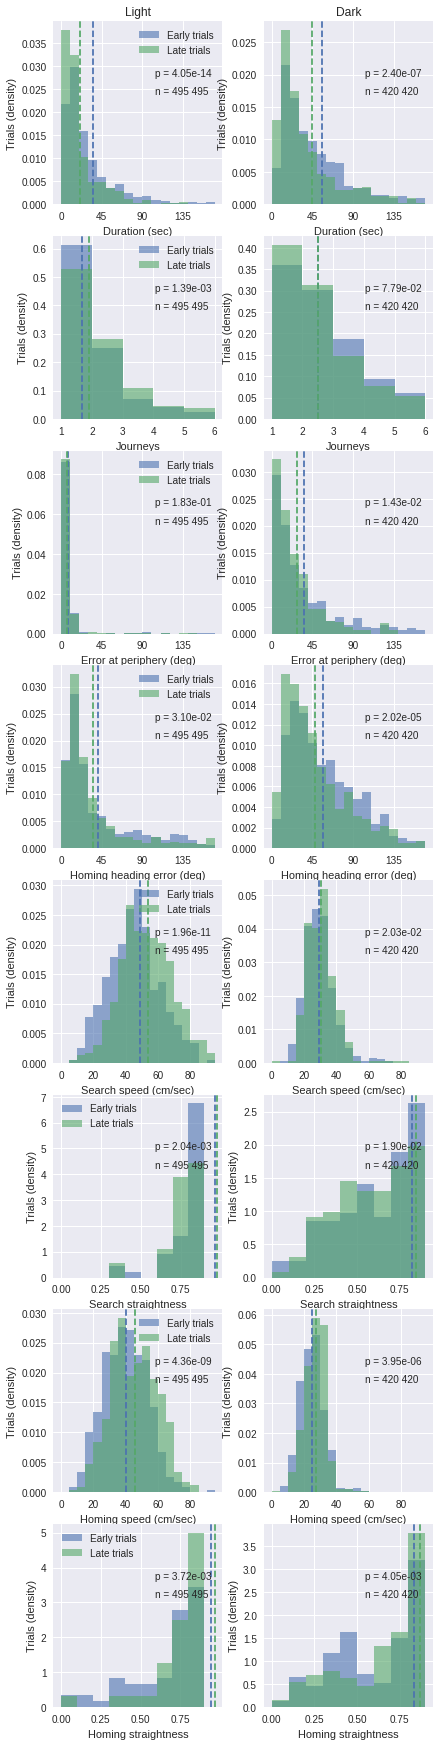

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.style.use("seaborn")

d = {"variable" : ["duration","nJourneys","angularErrorHomingPeri", 
                   "homingPeri_medianHDDeviationToTarget",
                   "searchArenaNoLever_meanSpeed","searchArenaNoLever_meanVectorLengthOri",
                   "homingPeri_meanSpeed","homingPeriNoLever_meanVectorLengthOri"], 
    "xMin" : [0,1,0,0,0,0,0,0],
     "xMax" : [180,7,180,180,100,1,100,1],
     "xStep" : [10,1, 10,10,5,0.1,5,0.1],
     "xTicksStep" : [45,1, 45,45,20,0.25,20,0.25],
     "xLabel": ["Duration (sec)", "Journeys", "Error at periphery (deg)", 
                "Homing heading error (deg)", 
                "Search speed (cm/sec)", "Search straightness", 
                "Homing speed (cm/sec)", "Homing straightness"]}

fig,axes = plt.subplots(len(d["variable"]),2,figsize=(6,len(d["variable"])*3))
plt.subplots_adjust(wspace=0.7,hspace=0.5)
fig.tight_layout()

for j, var in enumerate(d["variable"]):
    for i, lc in enumerate(["light","dark"]):
        if(j==0):
            axes[j,i].set_title(lc.capitalize())
      
        dataEarly = df[var][(df.light==lc) & (df.trialNoScaled<.25)]
        dataLate = df[var][(df.light==lc) & (df.trialNoScaled>.75)]
        axes[j,i].hist(dataEarly,density=True, alpha=0.6,label="Early trials",bins=np.arange(d["xMin"][j],d["xMax"][j],d["xStep"][j]))
        axes[j,i].hist(dataLate,density=True, alpha=0.6,label="Late trials",bins=np.arange(d["xMin"][j],d["xMax"][j],d["xStep"][j]))
        axes[j,i].axvline(x=np.nanmean(dataEarly),linestyle='dashed',color=sns.color_palette()[0])
        axes[j,i].axvline(x=np.nanmean(dataLate),linestyle='dashed',color=sns.color_palette()[1])
        axes[j,i].set_xticks(np.arange(d["xMin"][j],d["xMax"][j],d["xTicksStep"][j]))
        
        axes[j,i].set_xlabel(d["xLabel"][j])
        axes[j,i].set_ylabel("Trials (density)")
        stat,p_value = stats.mannwhitneyu(x=dataEarly, y =dataLate )
        axes[j,i].text(0.6,0.7,"p = {:.02e}".format(p_value),transform=axes[j,i].transAxes)
        axes[j,i].text(0.6,0.6,"n = {} {}".format(len(dataEarly),len(dataLate)),transform=axes[j,i].transAxes)
        axes[j,i].xaxis.set_label_coords(0.5,-0.12)
        #axes[j,i].yaxis.set_label_coords(-0.16, 0.5)
        if(i == 0):
            axes[j,i].legend()  

fileName = myProject.dataPath+"/results/within_session_changes_01.pdf"
print("Saving to " + fileName)
print("")
plt.savefig(fileName,bbox_inches = "tight")

Saving to /adata/projects/autopi_behavior_2021/results/within_session_changes_02.pdf



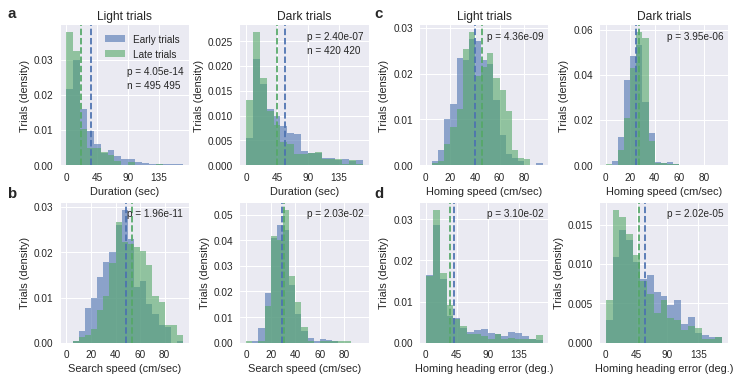

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.style.use("seaborn")

# create a dictionary that hold the variables that varies across graphs
d = {"variable" : ["duration",
                   "searchArenaNoLever_meanSpeed",
                   "homingPeri_meanSpeed",
                   "homingPeri_medianHDDeviationToTarget"], 
    "xMin" : [0,0,0,0],
     "xMax" : [180,100,100,180],
     "xStep" : [10,5,5,10],
     "xTicksStep" : [45, 20,20, 45],
     "xLabel": ["Duration (sec)",
                "Search speed (cm/sec)",
                "Homing speed (cm/sec)",
               "Homing heading error (deg.)"]}


fig,axes = plt.subplots(2,4,figsize=(10,5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.4,hspace=0.27)
plt.rcParams['ytick.major.pad'] = 2

for j, var in enumerate(d["variable"]):
    for i, lc in enumerate(["light","dark"]):
        xi=j%2 # index for subplot
        yi=i+(j//2)*2 # index for subplot
            
        if(xi==0):
            axes[xi,yi].set_title("{} trials".format(lc.capitalize()))
        # get the data 
        dataEarly = df[var][(df.light==lc) & (df.trialNoScaled<.25)]
        dataLate = df[var][(df.light==lc) & (df.trialNoScaled>.75)]
        #
        axes[xi,yi].hist(dataEarly,density=True, alpha=0.6,label="Early trials",bins=np.arange(d["xMin"][j],d["xMax"][j],d["xStep"][j]))
        axes[xi,yi].hist(dataLate,density=True, alpha=0.6,label="Late trials",bins=np.arange(d["xMin"][j],d["xMax"][j],d["xStep"][j]))
        axes[xi,yi].axvline(x=np.nanmean(dataEarly),linestyle='dashed',color=sns.color_palette()[0])
        axes[xi,yi].axvline(x=np.nanmean(dataLate),linestyle='dashed',color=sns.color_palette()[1])
        axes[xi,yi].set_xticks(np.arange(d["xMin"][j],d["xMax"][j],d["xTicksStep"][j]))
        axes[xi,yi].set_xlabel(d["xLabel"][j])
        axes[xi,yi].set_ylabel("Trials (density)")
      
        #axes[xi,yi].xaxis.set_label_coords(0.5,-0.11)
        #axes[j,i].yaxis.set_label_coords(-0.16, 0.5)
        if(i == j == 0):
            axes[xi,yi].legend()  
        stat,p_value = stats.mannwhitneyu(x=dataEarly, y =dataLate )
        if (xi == yi == 0):
            axes[xi,yi].text(0.52,0.65,"p = {:.02e}".format(p_value),transform=axes[xi,yi].transAxes)
            axes[xi,yi].text(0.52,0.55,"n = {} {}".format(len(dataEarly),len(dataLate)),transform=axes[xi,yi].transAxes)
        elif  xi==0 and yi==1:
            axes[xi,yi].text(0.52,0.9,"p = {:.02e}".format(p_value),transform=axes[xi,yi].transAxes)
            axes[xi,yi].text(0.52,0.8,"n = {} {}".format(len(dataEarly),len(dataLate)),transform=axes[xi,yi].transAxes)
        else :
            axes[xi,yi].text(0.52,0.9,"p = {:.02e}".format(p_value),transform=axes[xi,yi].transAxes)
           
        
axes[0,0].text(-0.03,0.98, 'a', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
axes[0,0].text(-0.03,0.48, 'b', style='normal',fontsize=15,  weight="bold",transform=plt.gcf().transFigure)
axes[0,0].text(0.48,0.98, 'c', style='normal',fontsize=15,  weight="bold",transform=plt.gcf().transFigure)
axes[0,0].text(0.48,0.48, 'd', style='normal',fontsize=15,  weight="bold",transform=plt.gcf().transFigure)
        
    
fileName = myProject.dataPath+"/results/within_session_changes_02.pdf"
print("Saving to " + fileName)
print("")
plt.savefig(fileName,bbox_inches = "tight")

## scp a230-pc73:/adata/projects/autopi_behavior_2021/results/within_session_changes_02.pdf .
## pdftoppm within_session_changes_02.pdf  within_session_changes_02 -png

Figre 4. **Changes in trial duration and running speed from early to late trials**. 
(**a**) Trial duration for early (first 25%) and late trials (last 25%). Left: Light trials, Right: Dark trials. The dashed line represents the mean of the distribution. 
(**b**, **c** and **d**) Same as **a** but for the mean running speed during the search, mean running speed during the homing path, and the homing heading error.
